In [2]:
## Set TensorFlow 2.0
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
## Librerias
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from xgboost import XGBClassifier

In [4]:
### Intalacion de librerias Talib
# download TA-Lib 
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 


!tar xvzf ta-lib-0.4.0-src.tar.gz

import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install

os.chdir('../')

!pip install TA-Lib

import talib

--2023-01-22 19:10:03--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-01-22 19:10:04--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://deac-fra.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-01-22 19:10:04--  http://deac-fra.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving deac-fra.dl.s

In [6]:
dataSetOriginal = pd.read_csv("/content/EURUSD_4H.csv")
#data["Date"] = pd.DatetimeIndex(data["Date"] )
#data = data.set_index("Date")
#dataSetOriginal = pd.read_csv(path)

dataSetOriginal.head(3)

,Date,Open,High,Low,Close,Volume
0,2010.01.04 00:00:00,1.43259,1.43336,1.42569,1.42939,6693
1,2010.01.04 04:00:00,1.42938,1.43090,1.42718,1.42949,4999
2,2010.01.04 08:00:00,1.42946,1.43994,1.42688,1.43778,10386


In [ ]:
# Enlace a Google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Acceso al file ubicado en Google Drive
path = "/content/drive/My Drive/Python  Notebooks/Trading 2020/Datos Historicos/EURUSD Daily.csv"
dataSetOriginal = pd.read_csv(path)

dataSetOriginal.head(3)

,Date,Open,High,Low,Close,Volume
0,2010.01.04 00:00:00,1.43259,1.44543,1.42569,1.44111,45505
1,2010.01.05 00:00:00,1.44107,1.44830,1.43467,1.43624,46686
2,2010.01.06 00:00:00,1.43632,1.44338,1.42831,1.43998,45435


In [7]:
### Analisis 

dataSet = dataSetOriginal.copy()

dataSet['NextUp'] = np.where(dataSet.Close.shift(-1) > dataSet.Close, 1, 0)
#dataSet['NextUp'] = dataSet.Close.shift(-1)

dataSet['Open/High']  = np.absolute(dataSet.Open  - dataSet.High)
dataSet['Open/Close'] = np.absolute(dataSet.Open  - dataSet.Close)
dataSet['Close/Low']  = np.absolute(dataSet.Close - dataSet.Low)
dataSet['High/Low']   = np.absolute(dataSet.High  - dataSet.Low)
dataSet['Up'] = np.where(dataSet.Close > dataSet.Open, 1, 0)
dataSet['Down'] = np.where(dataSet.Close < dataSet.Open, 1, 0)


Open = dataSet['Open'].values
High = dataSet['High'].values
Low  = dataSet['Low'].values
Close = dataSet['Close'].values
Volume = dataSet['Volume'].values/1

################# Indicadores de Talib ####################### 

dataSet['Upperband'], dataSet['Middleband'], dataSet['Lowerband'] = talib.BBANDS(Close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
dataSet['DEMA'] = talib.DEMA(Close, timeperiod=30)
dataSet['EMA'] = talib.EMA(Close, timeperiod=30)
dataSet['HT_TRENDLINE'] = talib.HT_TRENDLINE(Close)
dataSet['KAMA'] = talib.KAMA(Close, timeperiod=30)
dataSet['MA30'] = talib.MA(Close, timeperiod=30, matype=0)
dataSet['Mama'], dataSet['Fama'] = talib.MAMA(Close, fastlimit=0.5, slowlimit=0.05)
#dataSet['MAVP'] = talib.MAVP(Close, periods, minperiod=2, maxperiod=30, matype=0,)
dataSet['MIDPOINT'] = talib.MIDPOINT(Close, timeperiod=14)
dataSet['MIDPRICE'] = talib.MIDPRICE(High, Low, timeperiod=14)
dataSet['SAR'] = talib.SAR(High, Low, acceleration=0, maximum=0)
dataSet['SAREXT'] = talib.SAREXT(High, Low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
dataSet['SMA30'] = talib.SMA(Close, timeperiod=30)
dataSet['T3'] = talib.T3(Close, timeperiod=5, vfactor=0)
dataSet['TEMA'] = talib.TEMA(Close, timeperiod=30)
dataSet['TRIMA'] = talib.TRIMA(Close, timeperiod=30)
dataSet['WMA30'] = talib.WMA(Close, timeperiod=30)
#########################################
dataSet['ADX'] = talib.ADX(High, Low, Close, timeperiod=14)
dataSet['ADXR'] = talib.ADXR(High, Low, Close, timeperiod=14)
dataSet['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26, matype=0)
dataSet['Aroondown'], dataSet['Aroonup'] = talib.AROON(High, Low, timeperiod=14)
dataSet['AROONOSC'] = talib.AROONOSC(High, Low, timeperiod=14)
dataSet['BOP'] = talib.BOP(Open, High, Low, Close)
dataSet['CCI'] = talib.CCI(High, Low, Close, timeperiod=14)
dataSet['CMO'] = talib.CMO(Close, timeperiod=14)
dataSet['DX'] = talib.DX(High, Low, Close, timeperiod=14)
dataSet['Macd'], dataSet['Macdsignal'], dataSet['Macdhist'] = talib.MACD(Close, fastperiod=12, slowperiod=26, signalperiod=9)
dataSet['MacdEXT'], dataSet['MacdsignalEXT'], dataSet['MacdhistEXT'] = talib.MACDEXT(Close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
dataSet['MacdFIX'], dataSet['MacdsignalFIX'], dataSet['MacdhistFIX']= talib.MACDFIX(Close, signalperiod=9)
dataSet['MFI'] = talib.MFI(High, Low, Close, Volume, timeperiod=14)
dataSet['MINUS_DI'] = talib.MINUS_DI(High, Low, Close, timeperiod=14)
dataSet['MINUS_DM'] = talib.MINUS_DM(High, Low, timeperiod=14)
dataSet['MOM'] = talib.MOM(Close, timeperiod=10)
dataSet['PLUS_DI'] = talib.PLUS_DI(High, Low, Close, timeperiod=14)
dataSet['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)
dataSet['PPO'] = talib.PPO(Close, fastperiod=12, slowperiod=26, matype=0)
dataSet['ROC'] = talib.ROC(Close, timeperiod=10)
dataSet['ROCP'] = talib.ROCP(Close, timeperiod=10)
dataSet['ROCR'] = talib.ROCR(Close, timeperiod=10)
dataSet['ROCR100'] = talib.ROCR100(Close, timeperiod=10)
dataSet['RSI'] = talib.RSI(Close, timeperiod=14)
dataSet['SLowk'], dataSet['SLowd'] = talib.STOCH(High, Low, Close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
dataSet['Fastk'], dataSet['Fastd'] = talib.STOCHF(High, Low, Close, fastk_period=5, fastd_period=3, fastd_matype=0)
dataSet['FastkRSI'], dataSet['FastdRSI'] = talib.STOCHRSI(Close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
dataSet['TRIX'] = talib.TRIX(Close, timeperiod=30)
dataSet['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
dataSet['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)

##############################################################
dataSet['CROWS'] = talib.CDL2CROWS(Open, High, Low, Close)
dataSet['BLACKCROWS'] = talib.CDL3BLACKCROWS(Open, High, Low, Close)
dataSet['INSIDE'] = talib.CDL3INSIDE(Open, High, Low, Close)
dataSet['KINESTRIKE'] = talib.CDL3LINESTRIKE(Open, High, Low, Close)
dataSet['OUTSIDE'] = talib.CDL3OUTSIDE(Open, High, Low, Close)
dataSet['STARS'] = talib.CDL3STARSINSOUTH(Open, High, Low, Close)
dataSet['WHITESOLDIERS'] = talib.CDL3WHITESOLDIERS(Open, High, Low, Close)
dataSet['ABANDONED'] = talib.CDLABANDONEDBABY(Open, High, Low, Close, penetration=0)
dataSet['ADVANCEBLOCK'] = talib.CDLADVANCEBLOCK(Open, High, Low, Close)
dataSet['BELT'] = talib.CDLBELTHOLD(Open, High, Low, Close)
dataSet['BREAKAWAY'] = talib.CDLBREAKAWAY(Open, High, Low, Close)
dataSet['CLOSING'] = talib.CDLCLOSINGMARUBOZU(Open, High, Low, Close)
dataSet['CONCEAL'] = talib.CDLCONCEALBABYSWALL(Open, High, Low, Close)
dataSet['COUNTERATTACK'] = talib.CDLCOUNTERATTACK(Open, High, Low, Close)
dataSet['DARKCLOUND'] = talib.CDLDARKCLOUDCOVER(Open, High, Low, Close, penetration=0)
dataSet['DOJI'] = talib.CDLDOJI(Open, High, Low, Close)
dataSet['DOJISTAR'] = talib.CDLDOJISTAR(Open, High, Low, Close)
dataSet['DRAGOIN'] = talib.CDLDRAGONFLYDOJI(Open, High, Low, Close)
dataSet['LENGULFING'] = talib.CDLENGULFING(Open, High, Low, Close)
dataSet['EVENIN'] = talib.CDLEVENINGDOJISTAR(Open, High, Low, Close, penetration=0)
dataSet['EVENINGSTAR'] = talib.CDLEVENINGSTAR(Open, High, Low, Close, penetration=0)
dataSet['GAPS'] = talib.CDLGAPSIDESIDEWHITE(Open, High, Low, Close)
dataSet['GRAVES'] = talib.CDLGRAVESTONEDOJI(Open, High, Low, Close)
dataSet['HAMMER'] = talib.CDLHAMMER(Open, High, Low, Close)
dataSet['HANGING'] = talib.CDLHANGINGMAN(Open, High, Low, Close)
dataSet['HAMARI'] = talib.CDLHARAMI(Open, High, Low, Close)
dataSet['HAMARICROSS'] = talib.CDLHARAMICROSS(Open, High, Low, Close)
dataSet['HIGHWAVE'] = talib.CDLHIGHWAVE(Open, High, Low, Close)
dataSet['HIKKAKE'] = talib.CDLHIKKAKE(Open, High, Low, Close)
dataSet['HIKKAKEMOD'] = talib.CDLHIKKAKEMOD(Open, High, Low, Close)
dataSet['HOMING'] = talib.CDLHOMINGPIGEON(Open, High, Low, Close)
dataSet['IDENTICAL'] = talib.CDLIDENTICAL3CROWS(Open, High, Low, Close)
dataSet['INNECK'] = talib.CDLINNECK(Open, High, Low, Close)
dataSet['LINVER'] = talib.CDLINVERTEDHAMMER(Open, High, Low, Close)
dataSet['KICKING'] = talib.CDLKICKING(Open, High, Low, Close)
dataSet['KICKINGBY'] = talib.CDLKICKINGBYLENGTH(Open, High, Low, Close)
dataSet['LADDER'] = talib.CDLLADDERBOTTOM(Open, High, Low, Close)
dataSet['CDLLONGLEGGEDDOJI'] = talib.CDLLONGLEGGEDDOJI(Open, High, Low, Close)
dataSet['CDLLONGLINE'] = talib.CDLLONGLINE(Open, High, Low, Close)
dataSet['CDLMARUBOZU'] = talib.CDLMARUBOZU(Open, High, Low, Close)
dataSet['CDLMATCHINGLow'] = talib.CDLMATCHINGLOW(Open, High, Low, Close)
dataSet['CDLMATHOLD'] = talib.CDLMATHOLD(Open, High, Low, Close, penetration=0)
dataSet['CDLMORNINGDOJISTAR'] = talib.CDLMORNINGDOJISTAR(Open, High, Low, Close, penetration=0)
dataSet['CDLMORNINGSTAR'] = talib.CDLMORNINGSTAR(Open, High, Low, Close, penetration=0)
dataSet['CDLONNECK'] = talib.CDLONNECK(Open, High, Low, Close)
dataSet['CDLPIERCING'] = talib.CDLPIERCING(Open, High, Low, Close)
dataSet['CDLRICKSHAWMAN'] = talib.CDLRICKSHAWMAN(Open, High, Low, Close)
dataSet['CDLRISEFALL3METHODS'] = talib.CDLRISEFALL3METHODS(Open, High, Low, Close)
dataSet['CDLSEPARATINGLINES'] = talib.CDLSEPARATINGLINES(Open, High, Low, Close)
dataSet['CDLSHOOTINGSTAR'] = talib.CDLSHOOTINGSTAR(Open, High, Low, Close)
dataSet['CDLSHORTLINE'] = talib.CDLSHORTLINE(Open, High, Low, Close)
dataSet['CDLSPINNINGTOP'] = talib.CDLSPINNINGTOP(Open, High, Low, Close)
dataSet['CDLSTALLEDPATTERN'] = talib.CDLSTALLEDPATTERN(Open, High, Low, Close)
dataSet['CDLSTICKSANDWICH'] = talib.CDLSTICKSANDWICH(Open, High, Low, Close)
dataSet['CDLTAKURI'] = talib.CDLTAKURI(Open, High, Low, Close)
dataSet['CDLTASUKIGAP'] = talib.CDLTASUKIGAP(Open, High, Low, Close)
dataSet['CDLTHRUSTING'] = talib.CDLTHRUSTING(Open, High, Low, Close)
dataSet['CDLTRISTAR'] = talib.CDLTRISTAR(Open, High, Low, Close)
dataSet['CDLUNIQUE3RIVER'] = talib.CDLUNIQUE3RIVER(Open, High, Low, Close)
dataSet['CDLUPSIDEGAP2CROWS'] = talib.CDLUPSIDEGAP2CROWS(Open, High, Low, Close)
dataSet['CDLXSIDEGAP3METHODS'] = talib.CDLXSIDEGAP3METHODS(Open, High, Low, Close)

cols = dataSet.columns.to_list()
cols = cols[:6] + cols[7:] + cols[6:7]
dataSet = dataSet[cols]

dataSet.dropna(inplace=True)
print(dataSet.shape)
dataSet.head()

(15455, 133)


<ipython-input-7-8f551765d847>:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataSet['IDENTICAL'] = talib.CDLIDENTICAL3CROWS(Open, High, Low, Close)
<ipython-input-7-8f551765d847>:106: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataSet['INNECK'] = talib.CDLINNECK(Open, High, Low, Close)
<ipython-input-7-8f551765d847>:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

,Date,Open,High,Low,Close,Volume,Open/High,Open/Close,Close/Low,High/Low,...,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,NextUp
88,2010.01.22 16:00:00,1.41147,1.41807,1.40942,1.41493,12279,0.00660,0.00346,0.00551,0.00865,...,0,0,0,0,0,0,0,0,0,0
89,2010.01.22 20:00:00,1.41492,1.41558,1.41238,1.41363,5132,0.00066,0.00129,0.00125,0.00320,...,0,0,0,0,0,0,0,0,0,1
90,2010.01.25 00:00:00,1.41523,1.41733,1.41338,1.41651,5484,0.00210,0.00128,0.00313,0.00395,...,0,0,0,0,0,0,0,0,0,0
91,2010.01.25 04:00:00,1.41650,1.41703,1.41523,1.41596,4505,0.00053,0.00054,0.00073,0.00180,...,0,0,0,0,0,0,0,0,0,1
92,2010.01.25 08:00:00,1.41592,1.41918,1.41301,1.41911,9310,0.00326,0.00319,0.00610,0.00617,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#dataSet.drop(columns=['Date','Open','High','Low','Close','Volume'], inplace=True)

dataSet.drop(columns='Date', inplace=True)
print(dataSet.shape)
dataSet.tail()

(15455, 132)


,Open,High,Low,Close,Volume,Open/High,Open/Close,Close/Low,High/Low,Up,...,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,NextUp
15538,1.12124,1.12145,1.11987,1.12069,2730,0.00021,0.00055,0.00082,0.00158,0,...,0,0,0,0,0,0,0,0,0,1
15539,1.12069,1.12173,1.12027,1.12136,4916,0.00104,0.00067,0.00109,0.00146,1,...,0,0,0,0,0,0,0,0,0,1
15540,1.12136,1.12390,1.12086,1.12379,7507,0.00254,0.00243,0.00293,0.00304,1,...,0,0,0,0,0,0,0,0,0,0
15541,1.12381,1.12392,1.12160,1.12288,12156,0.00011,0.00093,0.00128,0.00232,0,...,0,0,0,0,0,0,0,0,0,0
15542,1.12290,1.12290,1.12144,1.12154,2280,0.00000,0.00136,0.00010,0.00146,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
### Crear Loopback
ncolumns = dataSet.shape[1]-1
for loops in range(1):
  for x in range(ncolumns):  
    name = dataSet.columns[x]+"-"+str(loops+1)
    dataSet[name] = dataSet[dataSet.columns[x]].shift(loops+1)

dataSet.dropna(inplace=True)
dataSet.head()
dataSet.shape

<ipython-input-9-4756fe2758c3>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataSet[name] = dataSet[dataSet.columns[x]].shift(loops+1)


(15454, 263)

In [10]:
### Prepros
X = dataSet.loc[:,dataSet.columns!='NextUp']
Y = dataSet.loc[:,'NextUp']

from sklearn import preprocessing
##### Min Max
norm = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
norm = min_max_scaler.fit_transform(norm)
dataSetNorm = pd.DataFrame(norm, columns=X.columns)
#####Std dev
std = dataSetNorm.values
std_norm = preprocessing.StandardScaler()
std = std_norm.fit_transform(std)
dataSetNorm = pd.DataFrame(std)
dataSetNorm.describe()


train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.3, shuffle=False)

In [11]:
X = dataSet.loc[:,dataSet.columns!='NextUp']
Y = dataSet.loc[:,'NextUp']
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.3, shuffle=True)

X.shape


(15454, 262)

In [12]:
### Correlacion de variables

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features




        Specs      Score
63      Fastk  27.160736
61      SLowk  22.104920
64      Fastd  22.104920
65   FastkRSI  21.371447
68     ULTOSC  20.470754
66   FastdRSI  15.250894
36        BOP  15.003231
69      WILLR  14.309550
199  ULTOSC-1  14.166808
58       ROCR  14.045226


/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 70  75  77  80  82  83 104 105 106 111 127 128 129 201 206 208 211 213
 214 235 236 237 242 258 259 260] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [13]:
### Mapa correlacion

import seaborn as sns

corrmat = dataFiltro.corr()
top_corr_features = corrmat.index
#sns.figure(figsize=(20,20))

#plot heat map
g=sns.heatmap(dataFiltro[top_corr_features].corr(),annot=True,cmap="RdYlGn")

NameError: ignored

In [14]:
### XGBoost best conf
#https://www.infopulse.com/blog/the-solution-to-binary-classification-task-using-xgboost-machine-learning-package/

model = XGBClassifier(base_score=0.5, 
                      booster='gbtree', 
                      colsample_bylevel=1,
                      colsample_bynode=1, 
                      colsample_bytree=1, 
                      gamma=0,
                      learning_rate=0.0005, 
                      max_delta_step=0, 
                      max_depth=1,
                      min_child_weight=1, 
                      missing=None, 
                      n_estimators=15000, 
                      n_jobs=-1,
                      nthread=None, 
                      objective='binary:logistic', 
                      random_state=15,
                      reg_alpha=0, 
                      reg_lambda=1, 
                      scale_pos_weight=1, 
                      seed=None,
                      silent=None, 
                      subsample=1, 
                      tree_method='auto', 
                      verbosity=1)

model.fit(train_x, train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=1500, eval_metric='error')

#model.score(test_x,test_y)

Se han truncado las últimas 5000 líneas del flujo de salida.
[1431]	validation_0-error:0.488462
[1432]	validation_0-error:0.488462
[1433]	validation_0-error:0.488462
[1434]	validation_0-error:0.488462
[1435]	validation_0-error:0.488462
[1436]	validation_0-error:0.488462
[1437]	validation_0-error:0.488462
[1438]	validation_0-error:0.488462
[1439]	validation_0-error:0.488462
[1440]	validation_0-error:0.488462
[1441]	validation_0-error:0.488462
[1442]	validation_0-error:0.488462
[1443]	validation_0-error:0.488462
[1444]	validation_0-error:0.488462
[1445]	validation_0-error:0.488462
[1446]	validation_0-error:0.488462
[1447]	validation_0-error:0.488462
[1448]	validation_0-error:0.488462
[1449]	validation_0-error:0.488462
[1450]	validation_0-error:0.488462
[1451]	validation_0-error:0.488462
[1452]	validation_0-error:0.488462
[1453]	validation_0-error:0.488462
[1454]	validation_0-error:0.488462
[1455]	validation_0-error:0.488462
[1456]	validation_0-error:0.488462
[1457]	validation_0-error:0.4

XGBClassifier(learning_rate=0.0005, max_depth=1, n_estimators=15000, n_jobs=-1,
              random_state=15, tree_method='auto')

In [15]:
######################################################

from sklearn.svm import  SVC

svclassifier = SVC(probability=True, kernel='poly',verbose=True, degree=4)
svclassifier.fit(train_x, train_y)

svclassifier.score(test_x, test_y)


[LibSVM]

0.50291136510675

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(train_x, train_y)

knn.score(test_x,test_y)

0.4968729782186759

In [17]:
#### Start TPU

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

KeyError: ignored

In [18]:

tf.keras.backend.clear_session()
tf.random.set_seed(56)

with strategy.scope():

  model = None
  model = Sequential()
  model.add(Dense(units=100, input_dim=train_x.shape[1], use_bias=False))
  model.add(Activation('tanh'))
  model.add(Dense(units=75, use_bias=False))
  model.add(Activation('tanh'))
  model.add(Dense(units=75, use_bias=False))
  model.add(Activation('tanh'))
  model.add(Dense(units=50, use_bias=False))
  model.add(Activation('tanh'))
  model.add(Dense(units=25, use_bias=False))
  model.add(Activation('tanh'))
  model.add(Dense(units=1, use_bias=False))
  model.add(Activation('sigmoid'))


  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(), metrics=[tf.keras.metrics.BinaryAccuracy()])
  print(model.summary())

### Entrenamiento de la Red Neuronal
earlyStop = EarlyStopping(monitor='loss', mode='auto', verbose=0, patience=1500, restore_best_weights=True)
history = model.fit(train_x, train_y, epochs=5500, batch_size=16, validation_data=(test_x,test_y), callbacks=[earlyStop], verbose=0, shuffle=True)

train_score = model.evaluate(train_x, train_y, batch_size=1)
print('Train accuracy:', train_score[1])
test_score = model.evaluate(test_x, test_y, batch_size=1) 
print('Test accuracy:', test_score[1])



NameError: ignored

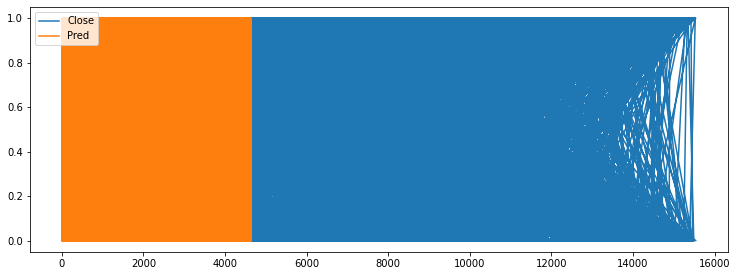

In [19]:
#### Plot
pred = model.predict(test_x)
pred

import matplotlib.pyplot as plt

plt.figure(figsize=(12.5, 4.5))
plt.plot(test_y, label='Close')
plt.plot(pred, label='Pred')
plt.legend(loc='upper left')
plt.show()

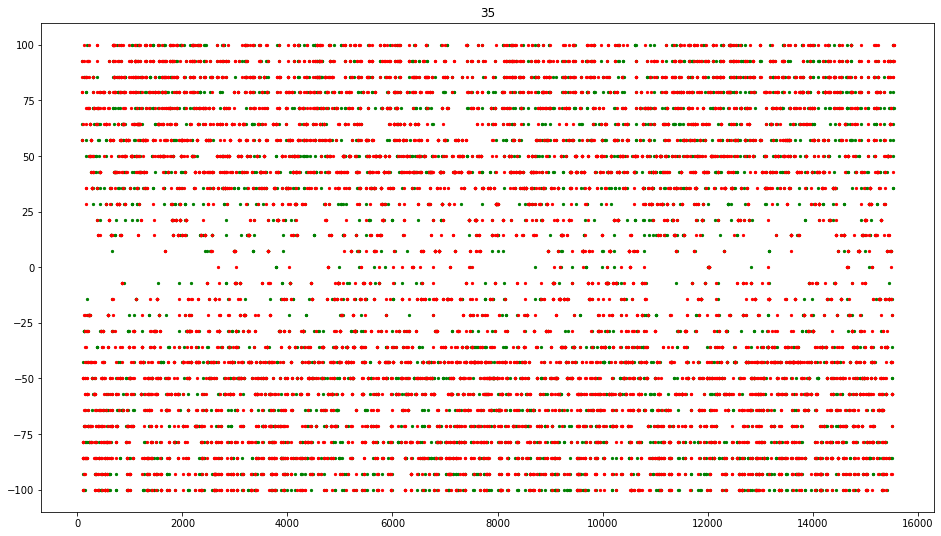

In [20]:
## plt variables
import matplotlib.pyplot as plt
variable = 35
dataUp = dataSet.loc[dataSet['NextUp']==1]
dataDown = dataSet.loc[dataSet['NextUp']==0]


plt.figure(figsize=(16,9), facecolor='white',)
plt.scatter(dataUp.index, dataUp[dataUp.columns[variable]], c='g', s=5)
plt.scatter(dataDown.index, dataDown[dataDown.columns[variable]], c='r', s=5)
plt.title(variable)
plt.show()

In [21]:
pred = model.predict(test_x)
pred

# plot history
from matplotlib import pyplot
pyplot.plot(history.history['binary_accuracy'], label='train')
pyplot.plot(history.history['val_binary_accuracy'], label='test')
pyplot.legend()
pyplot.show()

NameError: ignored